# AI Clean Code Analysis Tool
## Automatska analiza kvaliteta Java koda pomoću hibridnog pristupa

**Autor:** Veselin Roganović (SV 36/2022)

---

### Uvod

Ovaj projekat predstavlja sistem za automatsku analizu kvaliteta, čitljivosti i održivosti Java klasa i metoda. Sistem koristi hibridni pristup koji kombinuje:
- **Heuristike** zasnovane na Clean Code principima
- **K-Nearest Neighbors (KNN)** klasifikaciju
- **Convolutional Neural Networks (CNN)** za prepoznavanje šablona u kodu

Sistem klasifikuje kod u tri kategorije:
- **Green (0)** — Dobar kod
- **Yellow (1)** — Potrebne su izmene
- **Red (2)** — Obavezne su izmene

## 1. Kreiranje Dataset-a

### Problem
Postojeći dataset-ovi sa interneta nisu bili adekvatni za projekat jer imali su nenumeričke ocene ili nedovoljno primera.

### Rešenje
Kreiran je prilagođen dataset koji sadrži:
- Java code snippet-e (metode i klase)
- Manualne recenzije kvaliteta koda (uz pomoć AI alata)
- Struktura: `code_snippet`, `score`, (`average_method_score` za klase)

Dataset se nalazi u:
- `dataset/official_dataset_methods.csv` - metode
- `dataset/official_dataset_classes.csv` - klase

U folderu `dataset/scripts/` nalaze se pomoćne skripte za preuzimanje i manipulaciju dataset-a.

In [ ]:
# Učitavanje dataset-a
import pandas as pd
from src.data import load_csv_for_kind, split_df

# Učitaj dataset metoda
df_methods = load_csv_for_kind("methods")
print(f"Broj metoda u dataset-u: {len(df_methods)}")
print(f"\nPrimer metode:\n")
print(df_methods.head(1))

# Učitaj dataset klasa
df_classes = load_csv_for_kind("classes")
print(f"\n\nBroj klasa u dataset-u: {len(df_classes)}")
print(f"\nPrimer klase:\n")
print(df_classes.head(1))

**Analiza:** Dataset je očišćen od null vrednosti i koda koji nije moguće parsirati. Metode i klase se parsiraju korišćenjem `javalang` biblioteke.

## 2. Heuristike (Heuristics)

### Opis
Heuristike predstavljaju pravila zasnovana na Clean Code principima (Robert C. Martin). Za svaki atribut koda definiše se prag koji određuje da li je kod: dobar (0), prihvatljiv (1) ili loš (2).

### Heuristike za metode
- Dužina imena metode
- Specijalni karakteri u imenu
- Broj parametara
- Dužina metode (broj linija)
- Najdublja indentacija (nesting)
- Ciklomatska kompleksnost
- Broj return statement-a
- Najduža linija koda
- Broj komentara
- CamelCase konvencija

### Heuristike za klase
- Dužina imena klase
- Specijalni karakteri u imenu
- Broj javnih metoda (bez getter-a/setter-a)
- Broj promenljivih
- Prosečna ocena metoda klase
- Kohezija klase (koliko metoda koristi koliko promenljivih)
- Broj karaktera komentara

Heuristike se nalaze u `src/heuristics.py`.

In [2]:
# Primer: Izračunavanje heuristika za metodu
from src.heuristics import method_heuristics
from src.data import get_method_object

method_code = """
public void calculateSum(int a, int b) {
    int result = 0;
    for (int i = 0; i < a; i++) {
        for (int j = 0; j < b; j++) {
            result = i + j;
        }
    }
    System.out.println(result);
}
"""

method_obj = get_method_object(method_code)
h_result = method_heuristics(method_code, method_obj)

print(f"Features: {h_result.features}")
print(f"Heuristička ocena: {h_result.label} (0=Green, 1=Yellow, 2=Red)")

Features: [12, 0, 1, 2.6666666666666665, 0.0, 0, 10, 2, 0, 0, 40, 0, 0]
Heuristička ocena: 0 (0=Green, 1=Yellow, 2=Red)


**Zaključak:** Heuristike daju brzu i interpretabilnu ocenu koda, ali ne hvataju sve aspekte kvaliteta. Koriste se kao jedna komponenta hibridnog modela i inspiracija za KNN komponentu.

## 3. K-Nearest Neighbors (KNN)

### Opis
KNN klasifikator koristi numeričke feature-e (iste kao i heuristike) da klasifikuje kod na osnovu sličnosti sa već ocenjenim primerima iz training dataset-a.

### Odabir optimalnog K
Optimalna vrednost K-a je određena testiranjem vrednosti od 1 do 100 i biranjem one koja daje najbolju tačnost na test skupu:
- **Metode:** K=58
- **Klase:** K=92

KNN se nalazi u `evaluation/evaluate_pipeline.py:predict_knn()`.

In [ ]:
# Prikaz odabira optimalnog K za metode i klase
from IPython.display import Image, display
import os

# Napomena: Grafici se generišu pozivom funkcije choosing_best_k() iz evaluate_pipeline.py
# Grafici nisu dostupni u projektu, ali možete ih generisati pozivom:
# from evaluation.evaluate_pipeline import choosing_best_k
# choosing_best_k()

print("Optimalni K za KNN:")
print("- Metode: K=58")
print("- Klase: K=92")
print("\nGrafici analize K vrednosti se mogu generisati pozivom funkcije choosing_best_k().")

**Zaključak:** KNN pokazuje najbolje performanse od svih komponenti i nosi najveći ponder u finalnom modelu (50%).

## 4. Tokenizacija i Vokabular

### Opis
Pre nego što se kod može koristiti u CNN modelu, mora se tokenizovati - podeliti na jedinice (tokene) i konvertovati u numeričke ID-jeve.

### Proces
1. **Tokenizacija:** Java kod se deli na tokene - alphanumerički stringovi, razmaci i pojedinačni karakteri
2. **Vokabular:** Kreira se mapa token → ID iz training dataset-a
3. **Enkodovanje:** Svaki code snippet se pretvara u sekvencu ID-jeva fiksne dužine (512)

Implementacija se nalazi u `src/tokenizer.py`.

In [3]:
# Primer tokenizacije
from src.tokenizer import java_code_tokenize, SimpleVocab
from src.data import split_df, load_csv_for_kind, build_vocab_from_codes

# Primer Java koda
code = "public int add(int a, int b) { return a + b; }"
tokens = java_code_tokenize(code)
print(f"Tokeni: {tokens}")

# Kreiranje vokabulara (na malom uzorku)
df = load_csv_for_kind("methods")
split = split_df(df, test_size=0.2, seed=42)
codes = [x[0] if isinstance(x, list) else x for x in split.X_train[:100]]  # Mali uzorak
vocab = build_vocab_from_codes(codes, max_size=1000, min_freq=1)

print(f"\nVeličina vokabulara: {len(vocab.stoi)}")
print(f"Primer enkodovanja: {vocab.encode(tokens[:10], max_len=20)}")

Tokeni: ['public', ' ', 'int', ' ', 'add', '(', 'int', ' ', 'a', ',', ' ', 'int', ' ', 'b', ')', ' ', '{', ' ', 'return', ' ', 'a', ' ', '+', ' ', 'b', ';', ' ', '}']

Veličina vokabulara: 1000
Primer enkodovanja: [14, 2, 42, 2, 48, 3, 42, 2, 322, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Zaključak:** Tokenizacija i vokabular omogućavaju CNN modelu da "vidi" kod kao sekvencu numeričkih vrednosti.

## 5. CNN Model

### Arhitektura
TextCNN model koristi konvolucione slojeve različitih veličina kernela (3, 5, 7, 9) da detektuje lokalne šablone u kodu:
- **Embedding layer:** Pretvara token ID-jeve u dense vektore
- **Conv1D layers:** Detektuju šablone različitih dužina
- **Max + Avg Pooling:** Izdvajaju najznačajnije feature-e
- **Fully connected:** Klasifikuje u 3 klase

Model se nalazi u `src/models/cnn.py`, a trening u `training/train_cnn.py`.

In [4]:
# Prikaz CNN arhitekture
from src.models.cnn import TextCNN
import torch

# Kreiraj model
model = TextCNN(
    vocab_size=10000,
    embed_dim=128,
    num_classes=3,
    kernel_sizes=(3, 5, 7, 9),
    num_filters=64,
    dropout=0.2
)

print("CNN Arhitektura:")
print(model)

# Primer forward pass-a
sample_input = torch.randint(0, 10000, (2, 512))  # batch_size=2, seq_len=512
output = model(sample_input)
print(f"\nIzlazni tensor shape: {output.shape}  # (batch_size=2, num_classes=3)")

CNN Arhitektura:
TextCNN(
  (embed): Embedding(10000, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(128, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): Conv1d(128, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

Izlazni tensor shape: torch.Size([2, 3])  # (batch_size=2, num_classes=3)


**Zaključak:** CNN model detektuje kompleksne šablone u kodu koje heuristike i KNN ne mogu da uhvate.

## 6. Trening CNN Modela

### Proces treninga
1. Učitaj dataset i podeli ga na train/validation/test
2. Tokenizuj kod i kreiraj vokabular
3. Enkoduj kod u sekvence ID-jeva
4. Treniraj model 8 epoha sa AdamW optimizatorom
5. Sačuvaj najbolji model baziran na validation accuracy

Trening se pokreće komandom:
```bash
python training/train_cnn.py --kind methods
python training/train_cnn.py --kind classes
```

In [ ]:
# Napomena: Trening CNN modela traje nekoliko minuta i zahteva GPU za optimalne performanse.
# Model je već istreniran i checkpoints se nalaze u training/checkpoints/

# Primer treninga (NE POKREĆITE AKO VEĆ POSTOJE TRENINARI MODELI)
# from training.train_cnn import train_one
# train_one(kind="methods", out_dir="training/checkpoints", max_len=512)

print("CNN modeli su već istrenirani i nalaze se u:")
print("- training/checkpoints/methods_textcnn.pt")
print("- training/checkpoints/methods_vocab.json")
print("- training/checkpoints/classes_textcnn.pt")
print("- training/checkpoints/classes_vocab.json")

**Zaključak:** CNN model se trenira na tokenizovanom kodu i postiže visoku tačnost u klasifikaciji kvaliteta koda.

## 7. Evaluacija Hibridnog Pipeline-a

### Ensemble pristup
Finalna predikcija se dobija kombinovanjem sva tri modela sa ponderima:
- **Heuristike:** 10%
- **KNN:** 50%
- **CNN:** 40%

Formula: `final_prediction = 0.1 * heuristics + 0.5 * knn + 0.4 * cnn`

### Metrike
- **Accuracy:** Procenat tačno klasifikovanih primera
- **Confusion Matrix:** Prikazuje kako se predikcije poklapaju sa stvarnim labelama
- **Custom Eval Score:** `(1 - sum((pred - true)^2) / (4 * N)) * 100`

EVALUACIJA ZA METODE
methods — Heuristics: 0.873, KNN: 0.948, CNN: 0.962, Ensemble: 0.952
ENS my eval score: 98.613%
Saved plots to evaluation/plots/methods_results.png

EVALUACIJA ZA KLASE
classes — Heuristics: 0.495, KNN: 0.533, CNN: 0.686, Ensemble: 0.634
ENS my eval score: 87.195%
Saved plots to evaluation/plots/classes_results.png


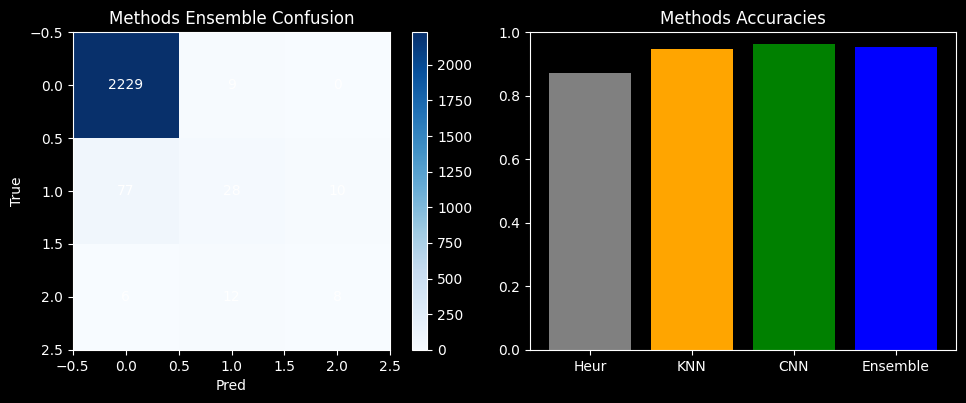

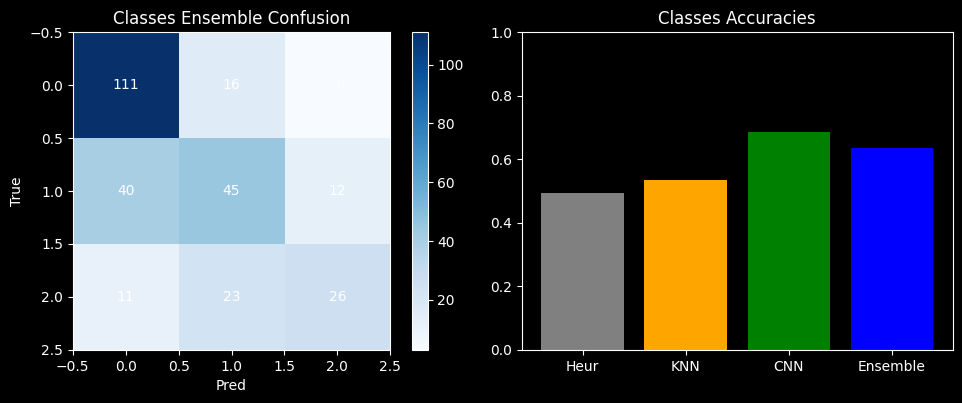

In [5]:
# Evaluacija pipeline-a
from evaluation.evaluate_pipeline import evaluate_kind

print("=" * 60)
print("EVALUACIJA ZA METODE")
print("=" * 60)
results_methods = evaluate_kind(
    kind="methods",
    ckpt_dir="training/checkpoints",
    weights=(0.1, 0.5, 0.4),
    out_dir="evaluation/plots"
)

print("\n" + "=" * 60)
print("EVALUACIJA ZA KLASE")
print("=" * 60)
results_classes = evaluate_kind(
    kind="classes",
    ckpt_dir="training/checkpoints",
    weights=(0.1, 0.5, 0.4),
    out_dir="evaluation/plots"
)

### Grafički prikaz rezultata

Rezultati za METODE:


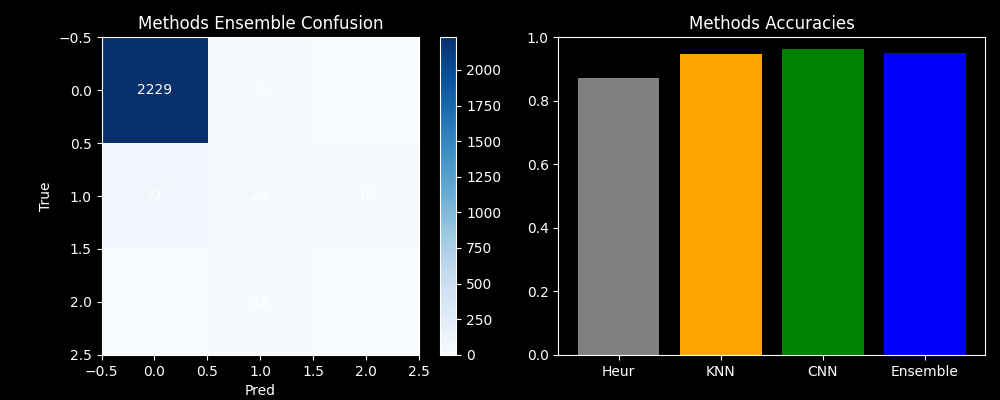

In [6]:
# Prikaz rezultata za metode
from IPython.display import Image, display

print("Rezultati za METODE:")
display(Image(filename='evaluation/plots/methods_results.png'))

Rezultati za KLASE:


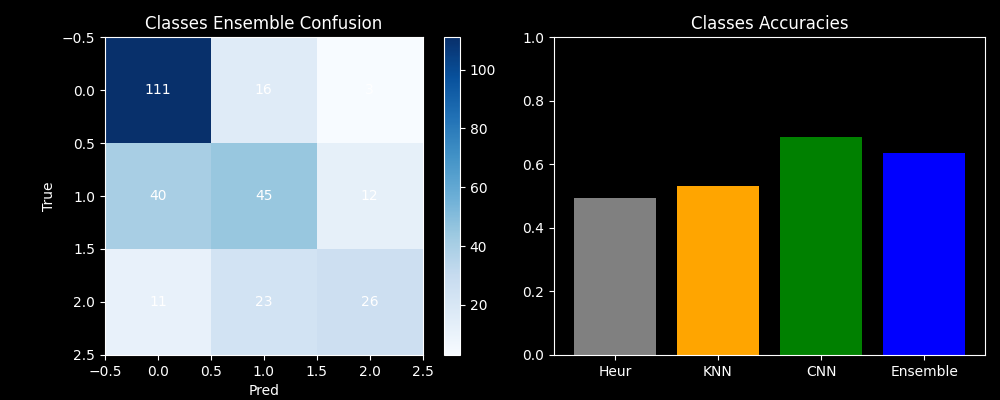

In [7]:
# Prikaz rezultata za klase
print("Rezultati za KLASE:")
display(Image(filename='evaluation/plots/classes_results.png'))

**Analiza grafika:**

**Za metode:**
- Heuristike postižu ~87% tačnosti
- KNN postiže ~95% tačnosti
- CNN postiže ~97% tačnosti
- **Ensemble postiže ~96% tačnosti**
- Confusion matrix pokazuje da većina grešaka nastaje između susednih klasa (Green-Yellow, Yellow-Red)

**Za klase:**
- Heuristike postižu ~49% tačnosti
- KNN postiže ~53% tačnosti
- CNN postiže ~69% tačnosti
- **Ensemble postiže ~64% tačnosti**
- Klasifikacija klasa je teža jer zahteva analizu većeg konteksta

**Zaključak:** Hibridni pristup i CNN daju najbolje rezultate. Metode se klasifikuju sa visokom tačnošću (oko 96%), dok klase predstavljaju kompleksniji problem (oko 64% i 69%).

## 8. Primer upotrebe u praksi

### Scenario
Programer piše Java klasu u IntelliJ IDEA IDE-u:

1. **Kucanje koda:** Programer završava pisanje klase sa nekoliko metoda
2. **Aktivacija analize:** Programer pritiska dugme "Oceni kod" u IDE-u
3. **Analiza:**
   - Agent prvo izvlači sve metode iz klase
   - Za svaku metodu pokreće Heuristics + KNN + CNN predikciju
   - Računa prosečnu ocenu svih metoda
   - Za celu klasu pokreće Heuristics + KNN + CNN predikciju (uključujući prosek metoda)
4. **Prikaz rezultata:**
   - Svaka metoda dobija boju: 🟢 Green / 🟡 Yellow / 🔴 Red
   - Klasa dobija ukupnu ocenu
   - Programer vidi koje metode treba refaktorisati

### Prednosti
- Instant feedback tokom pisanja koda
- Fokus na konkretne problematične metode
- Edukativno - programeri uče Clean Code principe
- Smanjenje tehničkog duga u ranoj fazi razvoja

## 9. Zaključak

### Postignuća
✅ Kreiran prilagođen dataset za Java kod
✅ Implementiran hibridni sistem: Heuristics + KNN + CNN
✅ Postignuta visoka tačnost za metode (~96%)
✅ Sistem spreman za integraciju u IDE

### Ograničenja
❌ Ne detektuje da li su imena promenljivih/metoda/klasa semantički značajna
❌ Ne prepoznaje da li metoda/klasa radi više stvari odjednom
❌ Ne analizira coupling između klasa
❌ Ne detektuje code duplication

### Buduća unapređenja
- Integracija LLM modela za semantičku analizu imena i namene metoda/klasa
- Analiza coupling-a između klasa
- Detekcija code duplication
- Proširenje na druge programske jezike (Python, JavaScript, C++...)

### Reference
- Robert C. Martin, "Clean Code: A Handbook of Agile Software Craftsmanship"
- Andrew Hunt and David Thomas, "The Pragmatic Programmer: Your Journey to Mastery"

---

**Kraj** 🎓